 Veri işleme, model oluşturma, hiperparametre arama ve değerlendirme için gerekli altyapı kurulmuş. 

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
import csv
from PIL import Image
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Dense, Input
from sklearn.cluster import KMeans
from sklearn.model_selection import ParameterGrid



GTSRB veri setindeki CSV dosyasını okuyarak görüntü yollarını ve sınıf etiketlerini birer liste olarak döndürür. Görüntü yolları belirtilen klasörle birleştirilir, etiketler int tipine dönüştürülür. Başlık satırı atlanarak veri işlenir.

In [ ]:
def load_gtsrb_dataset(csv_file, image_folder):
    images, labels = [], []
    with open(csv_file, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Skip header
        for row in reader:
            # Ensure the image path is treated as a string and leading zeros are preserved
            image_path = os.path.join(image_folder, str(row[7]))
            label = int(row[6])  # ClassId is at index 6
            images.append(image_path)
            labels.append(label)
    return images, labels

Verilen görüntü yollarından görüntüleri yükler, yeniden boyutlandırır ve düzleştirilmiş bir formatta bir numpy dizisi olarak döndürür. Her görüntü için yolu kontrol eder, geçerli bir uzantıya sahip olup olmadığını değerlendirir ve görüntüyü RGB formatına dönüştürüp boyutlandırır. Hatalı yollar veya yüklenemeyen görüntüler atlanır, işlem sırasında uyarı mesajları gösterilir.

In [ ]:
def load_and_preprocess_images(image_paths, image_size=(32, 32)):
    images = []
    for image_path in image_paths:
        print(f"Processing image: {image_path}") 
        full_path = Path(image_path).resolve()  # Get absolute path
        print(f"Full image path: {full_path}") 
        
        if full_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            try:
                if full_path.exists():
                    img = Image.open(full_path).convert('RGB')
                    img = img.resize(image_size)
                    img_array = np.array(img).flatten()
                    images.append(img_array)
                else:
                    print(f"Warning: {full_path} not found, skipping...")
            except Exception as e:
                print(f"Error processing {full_path}: {e}")
        else:
            print(f"Warning: {full_path} is not a valid image, skipping...")
    
    return np.array(images)

Eksik veya geçersiz veri içeren görüntü ve etiketleri temizler. Görüntü yollarının varlığını ve geçerli formatta olup olmadığını kontrol eder. Eksik etiketler varsayılan bir değerle doldurulabilir (fill_missing_labels), geçersiz yollar ise atlanır. Temizlenen görüntü ve etiket listeleri döndürülür.

In [13]:
def handle_missing_data(images, labels, fill_missing_labels=-1):
    valid_images, valid_labels = [], []
    
    for img_path, label in zip(images, labels):
        # Check if image path is valid (not missing and the file exists)
        img_path = Path(img_path)  # Ensure the image path is a Path object
        
        if img_path.exists() and img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:  # Check if valid image file
            if label is not None:  # Ensure label is not missing
                valid_images.append(img_path)
                valid_labels.append(label)
            else:
                print(f"Warning: Missing label for image {img_path}, filling with {fill_missing_labels}")
                valid_images.append(img_path)
                valid_labels.append(fill_missing_labels)
        else:
            print(f"Warning: Invalid image path {img_path}, skipping...")

    return valid_images, valid_labels

StandardScaler kullanarak eğitim ve test görüntülerine z-skoru standardizasyonu uygular. Eğitim setindeki veriler kullanılarak ölçeklendirme parametreleri hesaplanır ve aynı parametreler test setine uygulanır. Sonuç olarak, eğitim ve test görüntüleri, ölçeklendirilmiş numpy dizileri olarak döner. Bu işlem, modelin daha kararlı bir şekilde öğrenmesi için veri dağılımını standart hale getirir.

In [14]:
def scale_features(train_images, test_images):
    # StandardScaler (z-score standardization)
    scaler = StandardScaler()
    scaled_train_images = scaler.fit_transform(train_images)
    scaled_test_images = scaler.transform(test_images)

    return scaled_train_images, scaled_test_images

Verilen görüntüleri ve etiketleri eğitim ve test setlerine böler. test_size=0.2, verilerin %20'sinin test setine ayrılacağını belirtir. random_state=42 ise aynı bölmenin tekrarlanabilir olmasını sağlar. Fonksiyon, dört çıktıyı döner: train_images, test_images, train_labels ve test_labels.

In [15]:
def split_dataset(images, labels, test_size=0.2):
    return train_test_split(images, labels, test_size=test_size, random_state=42)


Veri kümesinin yüklenmesi, işlenmesi ve ölçeklendirilmesi için birden fazla adımı içerir:

* Veri Yükleme: load_gtsrb_dataset fonksiyonu kullanılarak, görüntü yolları ve etiketler csv_file ve image_folder dosyalarından yükleniyor.

* Eksik Verilerin İşlenmesi: handle_missing_data ile eksik veya geçersiz görüntü yolları ve etiketler temizleniyor. Temizlenmiş görüntü ve etiketler döndürülüyor.

* Veri Bölme: split_dataset fonksiyonu ile veri kümesi eğitim ve test setlerine ayrılıyor.

* Ön İşleme: Eğitim ve test görüntüleri, load_and_preprocess_images ile okunuyor, yeniden boyutlandırılıyor ve bir diziye dönüştürülüyor.

* Ölçeklendirme: scale_features ile z-skor standardizasyonu yapılarak veriler ölçeklendiriliyor.

Bu adımlar, modelin verimli bir şekilde eğitilmesi için veriyi hazır hale getirir. Kodun sonunda, ölçeklendirilmiş eğitim ve test görüntüleri ile etiketler, modelin eğitimi ve değerlendirilmesi için hazırdır.

In [16]:
# Paths to dataset files
csv_file = "dataset/gtsrb/Test.csv"
image_folder = "dataset/gtsrb"

# Load dataset
images, labels = load_gtsrb_dataset(csv_file, image_folder)

cleaned_images, cleaned_labels = handle_missing_data(images, labels)

# Split dataset
train_images, test_images, train_labels, test_labels = split_dataset(cleaned_images, cleaned_labels)

# Check how many images are in the dataset
print(f"Total training images: {len(train_images)}")  # Debugging: check train images
train_images_preprocessed = load_and_preprocess_images(train_images)
print(f"Total preprocessed training images: {len(train_images_preprocessed)}")  # Debugging: check preprocessed images

# Similarly for test images:
print(f"Total test images: {len(test_images)}")  # Debugging: check test images
test_images_preprocessed = load_and_preprocess_images(test_images)
print(f"Total preprocessed test images: {len(test_images_preprocessed)}")  # Debugging: check preprocessed test images

scaled_train_images, scaled_test_images = scale_features(train_images_preprocessed, test_images_preprocessed)


Total training images: 10104
Processing image: dataset/gtsrb/Test/06693.png
Full image path: /Users/mohammadsalah/Desktop/GTSRB/dataset/gtsrb/Test/06693.png
Processing image: dataset/gtsrb/Test/01845.png
Full image path: /Users/mohammadsalah/Desktop/GTSRB/dataset/gtsrb/Test/01845.png
Processing image: dataset/gtsrb/Test/00111.png
Full image path: /Users/mohammadsalah/Desktop/GTSRB/dataset/gtsrb/Test/00111.png
Processing image: dataset/gtsrb/Test/00472.png
Full image path: /Users/mohammadsalah/Desktop/GTSRB/dataset/gtsrb/Test/00472.png
Processing image: dataset/gtsrb/Test/11761.png
Full image path: /Users/mohammadsalah/Desktop/GTSRB/dataset/gtsrb/Test/11761.png
Processing image: dataset/gtsrb/Test/06149.png
Full image path: /Users/mohammadsalah/Desktop/GTSRB/dataset/gtsrb/Test/06149.png
Processing image: dataset/gtsrb/Test/07496.png
Full image path: /Users/mohammadsalah/Desktop/GTSRB/dataset/gtsrb/Test/07496.png
Processing image: dataset/gtsrb/Test/05453.png
Full image path: /Users/moha

MLP (Multi-layer Perceptron) modelini GridSearchCV ile hiperparametre optimizasyonu yaparak eğitir ve test eder. Hiperparametreler arasında hidden_layer_sizes, activation, learning_rate_init ve max_iter bulunur. GridSearchCV, bu parametrelerin her kombinasyonunu dener ve en iyi modeli seçer. Son olarak, en iyi modelin doğruluğu ve diğer metrikler (accuracy, classification_report) test verisiyle hesaplanır ve ekrana yazdırılır. Bu işlem modelin hiperparametrelerini optimize ederek daha iyi sonuçlar elde etmeyi hedefler.

In [22]:
# Grid Search for MLP
mlp_param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [200, 300]
}

mlp = MLPClassifier(random_state=42)

# Perform GridSearchCV for hyperparameter tuning
mlp_grid_search = GridSearchCV(estimator=mlp, param_grid=mlp_param_grid, scoring='accuracy', cv=3)
mlp_grid_search.fit(train_images_preprocessed, train_labels)

# Best MLP model
best_mlp = mlp_grid_search.best_estimator_

# Evaluate the best MLP model on test data
mlp_predictions = best_mlp.predict(test_images_preprocessed)

# Output evaluation metrics
print("MLP Model Accuracy:", accuracy_score(test_labels, mlp_predictions))
print(classification_report(test_labels, mlp_predictions))


/Users/mohammadsalah/Desktop/GTSRB/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mohammadsalah/Desktop/GTSRB/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mohammadsalah/Desktop/GTSRB/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mohammadsalah/Desktop/GTSRB/.venv/lib/python3.12/si

MLP Model Accuracy: 0.9045922406967538
              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.98      0.84      0.91       148
           2       0.81      0.96      0.88       138
           3       0.90      0.78      0.84        92
           4       0.95      0.85      0.90       119
           5       0.74      0.94      0.83       108
           6       0.97      0.97      0.97        33
           7       0.87      0.79      0.83        82
           8       0.97      0.79      0.87        86
           9       0.97      0.96      0.97       107
          10       0.78      1.00      0.88       124
          11       0.98      0.92      0.95        86
          12       0.98      0.96      0.97       141
          13       0.97      0.98      0.97       138
          14       0.98      0.96      0.97        57
          15       0.88      0.86      0.87        50
          16       1.00      0.93      0.9

K-means algoritmasıyla elde edilen merkezleri kullanarak bir Gaussian RBF katmanı oluşturur. Model, giriş verilerini bu merkezlerle karşılaştırarak RBF fonksiyonunu uygular. KMeans ile belirlenen kümeler, modelin öğrenmesi için kullanılır. Modelde, RBF katmanının ardından bir ReLU gizli katman ve Sigmoid çıkış katmanı bulunur. Model, Adam optimizasyonu ve binary_crossentropy kayıp fonksiyonu ile derlenir. Bu, ikili sınıflandırma problemleri için uygun bir yapıdır.

In [32]:


class RBFLayer(Layer):
    def __init__(self, centers, sigma=1.0, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.centers = tf.constant(centers, dtype=tf.float32)
        self.sigma = sigma

    def call(self, inputs):
        # Calculate Euclidean distance between inputs and centers
        distances = tf.norm(tf.expand_dims(inputs, 1) - self.centers, axis=-1)
        # Apply Gaussian RBF formula
        return tf.exp(-distances ** 2 / (2 * self.sigma ** 2))


def create_rbf_model_with_kmeans(input_dim, train_images, n_centers=200, sigma=1.0):
    # Compute K-means centers
    kmeans = KMeans(n_clusters=n_centers, random_state=42)
    kmeans.fit(train_images)
    centers = kmeans.cluster_centers_

    # Create the model
    inputs = Input(shape=(input_dim,))
    rbf_layer = RBFLayer(centers=centers, sigma=sigma)(inputs)
    dense1 = Dense(64, activation='relu')(rbf_layer)
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model




Verilerin ölçeklendirilip etiketlerin yeniden şekillendirilmesinin ardından K-means ile elde edilen merkezlerle bir RBF modeli oluşturur. Model, 20 epoch boyunca eğitim verisiyle eğitilir ve test verisiyle tahmin yapılır. Doğruluk, tahmin edilen ve gerçek etiketler arasındaki karşılaştırmayla hesaplanır ve ekrana yazdırılır.

In [33]:
# Scale the features
scaled_train_images, scaled_test_images = scale_features(train_images_preprocessed, test_images_preprocessed)

# Reshape labels for Keras
train_labels = np.array(train_labels).reshape(-1, 1)
test_labels = np.array(test_labels).reshape(-1, 1)

# Create and train the RBF model
input_dim = scaled_train_images.shape[1]
rbf_model = create_rbf_model_with_kmeans(input_dim=input_dim, train_images=scaled_train_images, n_centers=200, sigma=1.0)
rbf_model.fit(scaled_train_images, train_labels, epochs=20, batch_size=32, validation_data=(scaled_test_images, test_labels))

# Predict and evaluate
predictions = rbf_model.predict(scaled_test_images)
predictions = (predictions > 0.5).astype(int)
accuracy = accuracy_score(test_labels, predictions)
print(f"RBF Model Accuracy: {accuracy}")

Epoch 1/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0557 - loss: -15.8552 - val_accuracy: 0.0586 - val_loss: -129.3048
Epoch 2/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0545 - loss: -198.9745 - val_accuracy: 0.0586 - val_loss: -496.6705
Epoch 3/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0594 - loss: -606.1831 - val_accuracy: 0.0586 - val_loss: -1084.3474
Epoch 4/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0567 - loss: -1245.7397 - val_accuracy: 0.0586 - val_loss: -1868.2729
Epoch 5/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0577 - loss: -1998.5270 - val_accuracy: 0.0586 - val_loss: -2832.2371
Epoch 6/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0566 - loss: -3053.7827 - val_accuracy: 0.0586 - val_loss: -3954.5266
Epoch 7/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0577 - loss: -4141.8232 - val_accuracy: 0.0586 - val_loss: -5228.7749
Epoch 8/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - 

MLP ve RBF modelleri için karışıklık matrisi (confusion matrix) ve performans metriklerini hesaplar ve görselleştirir. Her iki modelin sonuçları Seaborn heatmap ile görselleştirilir. Ayrıca, her modelin doğruluk, precision, recall ve F1 skoru gibi performans metrikleri classification_report ile yazdırılır. np.round(predictions) ile RBF modelinin sürekli değerleri sınıf etiketlerine dönüştürülür.

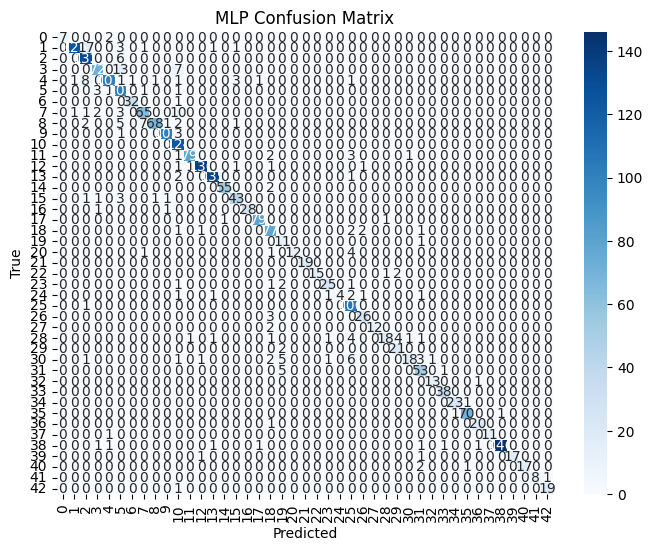

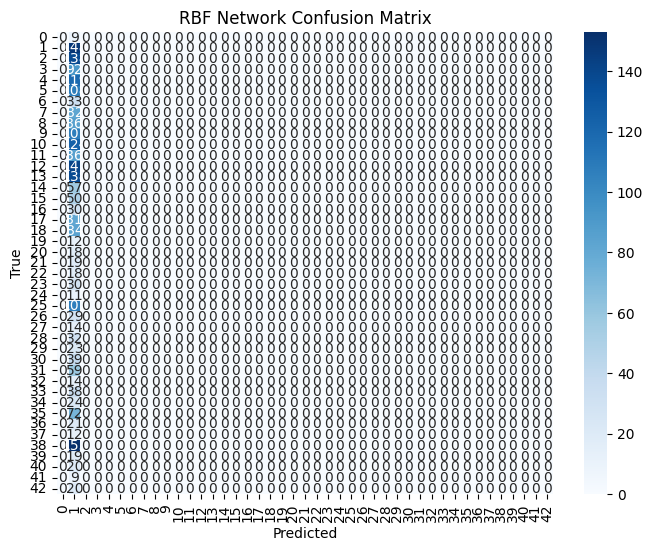

MLP Model Performance Metrics:
              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.98      0.84      0.91       148
           2       0.81      0.96      0.88       138
           3       0.90      0.78      0.84        92
           4       0.95      0.85      0.90       119
           5       0.74      0.94      0.83       108
           6       0.97      0.97      0.97        33
           7       0.87      0.79      0.83        82
           8       0.97      0.79      0.87        86
           9       0.97      0.96      0.97       107
          10       0.78      1.00      0.88       124
          11       0.98      0.92      0.95        86
          12       0.98      0.96      0.97       141
          13       0.97      0.98      0.97       138
          14       0.98      0.96      0.97        57
          15       0.88      0.86      0.87        50
          16       1.00      0.93      0.97       

/Users/mohammadsalah/Desktop/GTSRB/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mohammadsalah/Desktop/GTSRB/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mohammadsalah/Desktop/GTSRB/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [34]:
# Confusion Matrix and Performance Metrics

# MLP Confusion Matrix
mlp_cm = confusion_matrix(test_labels, mlp_predictions)

# RBF Confusion Matrix (rounded predictions as it's for classification)
rbf_cm = confusion_matrix(test_labels, np.round(predictions))

# Plotting the confusion matrices using Seaborn heatmap
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot confusion matrices for both models
plot_confusion_matrix(mlp_cm, 'MLP')
plot_confusion_matrix(rbf_cm, 'RBF Network')

# MLP Performance Metrics
print("MLP Model Performance Metrics:")
print(classification_report(test_labels, mlp_predictions))

# RBF Network Performance Metrics (rounded predictions)
print("RBF Network Performance Metrics:")
print(classification_report(test_labels, np.round(predictions)))

MLPClassifier (çok katmanlı algılayıcı) modeli için hiperparametre optimizasyonu yapmak amacıyla GridSearchCV kullanır. Belirtilen hiperparametreler için geniş bir arama yapılır: hidden_layer_sizes, activation, solver, alpha, ve learning_rate. 

GridSearchCV ile yapılan bu arama, doğruluk skorunu (accuracy) en yüksek yapan en iyi parametre kombinasyonlarını bulur. Ardından, en iyi modelle test verileri üzerinde tahminler yapılır ve test setindeki doğruluk skoru yazdırılır. Bu işlem, modelin en iyi hiperparametreleriyle test verisi üzerinde ne kadar iyi performans gösterdiğini gösterir.

In [ ]:
mlp_params = {
    'hidden_layer_sizes': [(64,), (128,), (64, 32)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}

mlp = MLPClassifier(max_iter=200, random_state=42)
grid_search_mlp = GridSearchCV(estimator=mlp, param_grid=mlp_params, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_mlp.fit(scaled_train_images, train_labels)

# En iyi hiperparametreleri ve performansı yazdırın
print("En İyi MLP Hiperparametreler:", grid_search_mlp.best_params_)
print("En İyi MLP Doğruluk Skoru:", grid_search_mlp.best_score_)

# Test setinde en iyi model ile değerlendirme
mlp_best = grid_search_mlp.best_estimator_
mlp_predictions = mlp_best.predict(scaled_test_images)
print("Test Seti Doğruluğu (MLP):", accuracy_score(test_labels, mlp_predictions))


Fitting 3 folds for each of 48 candidates, totalling 144 fits


/Users/mohammadsalah/Desktop/GTSRB/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mohammadsalah/Desktop/GTSRB/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mohammadsalah/Desktop/GTSRB/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mohammadsalah/Desktop/GTSRB/.venv/lib/python3.12/si

KeyboardInterrupt: 

RBF modelinin hiperparametrelerini optimize etmek için birkaç kombinasyonu dener. n_centers, sigma, ve dense_units parametrelerinin farklı değerlerini test eder ve her bir kombinasyon için modelin doğruluğunu hesaplar. En yüksek doğruluğu veren model ve hiperparametreler kaydedilir ve yazdırılır.

Adımlar:

1. Hiperparametreler (n_centers, sigma, dense_units) için farklı değerler belirlenir.
2. Her kombinasyonla model oluşturulur ve eğitilir.
3. Test setinde doğruluk hesaplanır.
4. En iyi doğrulukla elde edilen parametreler yazdırılır.

In [ ]:

# Hiperparametre kombinasyonları
rbf_params = {
    'n_centers': [50, 100, 200],
    'sigma': [0.5, 1.0, 2.0],
    'dense_units': [32, 64]
}

best_rbf_model = None
best_accuracy = 0
best_params = None

for params in ParameterGrid(rbf_params):
    print(f"Deneme: {params}")
    rbf_model = create_rbf_model_with_kmeans(
        input_dim=input_dim,
        train_images=scaled_train_images,
        n_centers=params['n_centers'],
        sigma=params['sigma']
    )
    rbf_model.layers[2].units = params['dense_units']  # Modify dense layer units
    rbf_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    rbf_model.fit(scaled_train_images, train_labels, epochs=10, batch_size=64, verbose=0)
    
    # Test seti değerlendirme
    predictions = rbf_model.predict(scaled_test_images)
    predictions = (predictions > 0.5).astype(int)
    acc = accuracy_score(test_labels, predictions)
    print(f"Doğruluk (RBF): {acc}")
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_rbf_model = rbf_model
        best_params = params

print("En İyi RBF Hiperparametreler:", best_params)
print("En İyi RBF Doğruluk Skoru:", best_accuracy)


Deneme: {'dense_units': 32, 'n_centers': 50, 'sigma': 0.5}
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Doğruluk (RBF): 0.05859065716547902
Deneme: {'dense_units': 32, 'n_centers': 50, 'sigma': 1.0}
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Doğruluk (RBF): 0.05859065716547902
Deneme: {'dense_units': 32, 'n_centers': 50, 'sigma': 2.0}
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Doğruluk (RBF): 0.05859065716547902
Deneme: {'dense_units': 32, 'n_centers': 100, 'sigma': 0.5}
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Doğruluk (RBF): 0.05859065716547902
Deneme: {'dense_units': 32, 'n_centers': 100, 'sigma': 1.0}
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Doğruluk (RBF): 0.05859065716547902
Deneme: {'dense_units': 32, 'n_centers': 100, 'sigma': 2.0}
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Doğruluk (RBF): 0.05859065716547902
Deneme: {'dense_units': 32, 'n_centers': 200, 'sigma': 0.5}
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Doğruluk (RBF): 0.05859065716547902
Deneme: {'dense_units': 32, 'n_centers': 200, 'sigma': 1.0